# Task 1

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

def mediacol(df):
     for col in df.columns:
        if df[col].dtype == 'object':
            # Converte la notazione scientifica con virgola in punto
            df[col] = df[col].str.replace(',', '.', regex=False)
        # Converte in numerico, gli errori diventano NaN (Not a Number)
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Calcola la media della colonna (ignorando NaN) e arrotonda
        media_col = df[col].mean().round(0)
        
        # Se la media è un numero valido, sostituisce i NaN con la media
        if not np.isnan(media_col):
            df[col] = df[col].fillna(media_col)
    
     return df

def colabs(df):
    for col in df.columns:
        df[col] = df[col].abs()
    return df

def puliziadf(file_path):
    df = pd.read_csv(file_path, sep = ';')
    clean_df = df.copy()
    clean_df= clean_df[clean_df['Label'].notnull() & (clean_df['Label'] != '')] #rimuove le righe con Label nullo o stringa vuota prima di imettere i valori medi
    clean_df = mediacol(clean_df)
    clean_df = colabs(clean_df)
     
    posts_col = '#postshared'
    urls_col = '#urlshared'
    photos_col = '#photos/videos'

    # Evita la divisione per zero. Inizializza le colonne a 0.
    clean_df['fpurls'] = 0.0
    clean_df['fpphotos/videos'] = 0.0
        
    # Calcola la frazione solo dove il numero di post è maggiore di zero
    mask = clean_df[posts_col] > 0
    clean_df.loc[mask, 'fpurls'] = (clean_df.loc[mask, urls_col] / clean_df.loc[mask, posts_col]).round(3)
    clean_df.loc[mask, 'fpphotos/videos'] = (clean_df.loc[mask, photos_col] / clean_df.loc[mask, posts_col]).round(3)
    clean_df.to_csv('training_manual.csv', sep=';', index=False)

    return clean_df


In [39]:


class ManualNaiveBayes:
    
    def fit(self, X, y):
        self._unique_classes = np.unique(y)
        self._class_statistics = {}
        total_samples = X.shape[0] 

        for current_class_label in self._unique_classes:
            samples_in_current_class = X[y == current_class_label]
            
            mean_features = samples_in_current_class.mean(axis=0)
            # Aggiungiamo un piccolo valore per evitare divisioni per zero
            variance_features = samples_in_current_class.var(axis=0) + 1e-5
            
            # Calcola la probabilità a priori di questa classe
            prior_probability = samples_in_current_class.shape[0] / float(total_samples)
            
            self._class_statistics[current_class_label] = {
                'mean': mean_features,
                'variance': variance_features,
                'prior_prob': prior_probability
            }
    
    def _calculate_gaussian_pdf(self, features, mean, variance):
    
        numerator = np.exp(- (features - mean)**2 / (2 * variance))
        denominator = np.sqrt(2 * np.pi * variance)
        return numerator / denominator
    
    def _predict_single_sample(self, sample_features):

        log_posteriors_per_class = []

        for class_label in self._unique_classes:
            stats = self._class_statistics[class_label]
            
            log_prior = np.log(stats['prior_prob'])
            
            # Somma dei logaritmi delle PDF delle singole feature
            log_likelihood = np.sum(np.log(
                self._calculate_gaussian_pdf(sample_features, stats['mean'], stats['variance'])
            ))
            
            # La probabilità a posteriori logaritmica è la somma del log-prior e del log-likelihood
            total_log_posterior = log_prior + log_likelihood
            log_posteriors_per_class.append(total_log_posterior)
        
        # Restituisce la classe con la probabilità a posteriori logaritmica più alta
        predicted_index = np.argmax(log_posteriors_per_class)
        return self._unique_classes[predicted_index]

    def predict(self, X):
        predictions = []
        for sample_features in X:
            # Delega la previsione del singolo campione al metodo ausiliario
            predicted_class = self._predict_single_sample(sample_features)
            predictions.append(predicted_class)
            
        return np.array(predictions)

In [40]:
class ManualKNN:
    # ... (codice del classificatore KNN come prima)
    def __init__(self, k=3): 
        self.k = k

    def fit(self, X, y): 
        self.X_train, self.y_train = X, y
        
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])
        
    def _predict_single(self, x):
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

In [41]:

class SimpleDecisionTreeClassifier:
    """Costruzione manuale di un albero decisionale per classificazione."""

    def __init__(self, max_levels=5, min_samples=2):
        self.max_levels = max_levels
        self.min_samples = min_samples
        self.root = None
        self.label_encoder = {}
        self.label_decoder = []

    def train(self, features, labels):
        self.label_decoder = np.unique(labels)
        self.label_encoder = {label: idx for idx, label in enumerate(self.label_decoder)}
        encoded_labels = np.array([self.label_encoder[label] for label in labels])

        self.n_attributes = features.shape[1]
        self.root = self._build_node(features, encoded_labels, level=0)

    def classify(self, features):
        predictions = [self.label_decoder[self._classify_row(row, self.root)] for row in features]
        return np.array(predictions)

    def _classify_row(self, row, node):
        while "attribute" in node:
            if row[node["attribute"]] < node["cutoff"]:
                node = node["left_branch"]
            else:
                node = node["right_branch"]
        return node["class"]

    def _build_node(self, data, labels, level):
        num_samples = len(labels)
        unique_classes = np.unique(labels)

        # Condizioni di arresto
        if level >= self.max_levels or num_samples < self.min_samples or len(unique_classes) == 1:
            return {"class": self._most_frequent_class(labels)}

        best_attr, best_split = self._find_optimal_split(data, labels)
        if best_attr is None:
            return {"class": self._most_frequent_class(labels)}

        mask_left = data[:, best_attr] < best_split
        mask_right = ~mask_left

        if np.sum(mask_left) == 0 or np.sum(mask_right) == 0:
            return {"class": self._most_frequent_class(labels)}

        left_subtree = self._build_node(data[mask_left], labels[mask_left], level + 1)
        right_subtree = self._build_node(data[mask_right], labels[mask_right], level + 1)

        return {
            "attribute": best_attr,
            "cutoff": best_split,
            "left_branch": left_subtree,
            "right_branch": right_subtree
        }

    def _find_optimal_split(self, data, labels):
        best_gain = -np.inf
        best_attr = None
        best_value = None

        for i in range(self.n_attributes):
            values = np.unique(data[:, i])
            for val in values:
                gain = self._calculate_gain(data, labels, i, val)
                if gain > best_gain:
                    best_gain = gain
                    best_attr = i
                    best_value = val
        return best_attr, best_value

    def _calculate_gain(self, data, labels, attr_index, threshold):
        full_entropy = self._compute_entropy(labels)
        mask = data[:, attr_index] < threshold
        left_labels, right_labels = labels[mask], labels[~mask]

        if len(left_labels) == 0 or len(right_labels) == 0:
            return 0

        weight_left = len(left_labels) / len(labels)
        weight_right = len(right_labels) / len(labels)
        entropy_split = (
            weight_left * self._compute_entropy(left_labels)
            + weight_right * self._compute_entropy(right_labels)
        )

        return full_entropy - entropy_split

    def _compute_entropy(self, labels):
        if len(labels) == 0:
            return 0
        counts = np.bincount(labels)
        probs = counts[counts > 0] / len(labels)
        return -np.sum(probs * np.log2(probs))

    def _most_frequent_class(self, labels):
        return Counter(labels).most_common(1)[0][0]

    

Anteprima dataset manuale:
   profile id  #friends  #following  #community  age  #postshared  #urlshared  \
0           1        39         300         907  200         1000         850   
1           2       150         350          30  300          300         100   
2           3       300         450          50  465          500         150   
3           4        25         110         660  350         2050        2000   
4           5        24         100         150  800          950        1000   

   #photos/videos  fpurls  fpphotos/videos  avgcomment/post  likes/post  \
0             922   0.850            0.922               56          47   
1             290   0.333            0.967                5          12   
2             450   0.300            0.900                4          15   
3            2050   0.976            1.000                7           3   
4             900   1.053            0.947               66           5   

   tags/post  #tags/post  Label  
0

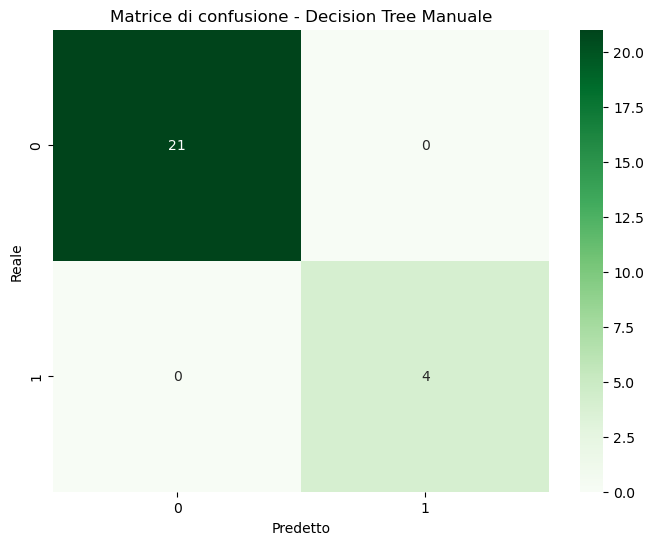

Naive Bayes Manuale - Accuracy: 0.960


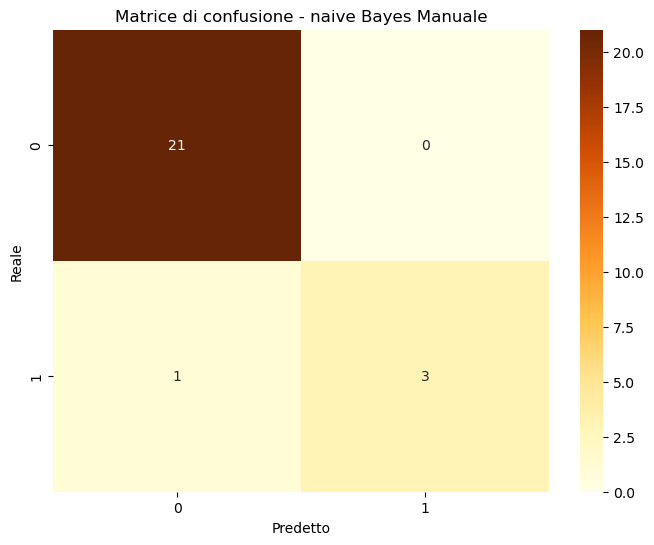


Manual KNN - Accuracy: 0.920


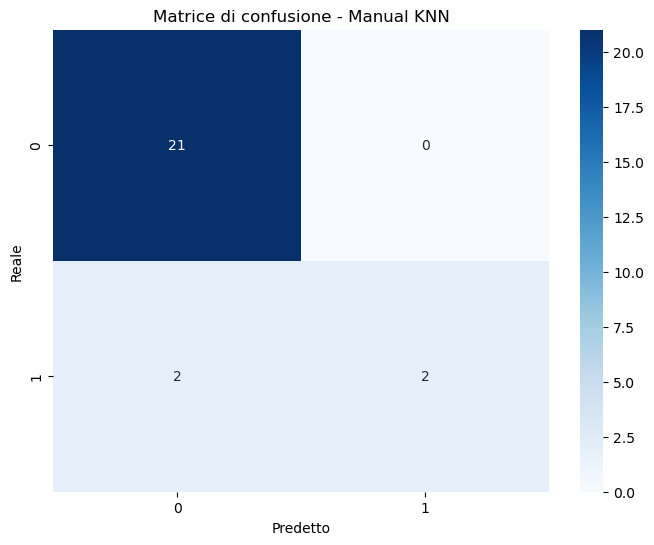


Migliore classificatore manuale: Decision tree
Data Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00         4

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Data Naive Bayes

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.75      0.86         4

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25

Data KNN

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.50      0.67         4

    accuracy                           0.92        25
   macro avg       0.96      0.7

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

manuale_df = pd.read_csv('clean_manual.csv', sep = ';')
print("Anteprima dataset manuale:")
print(manuale_df.head())



feature_cols = ['#friends', '#following', '#community', 'age', '#postshared', '#urlshared', '#photos/videos', 'fpurls',
                'fpphotos/videos', 'avgcomment/post', 'likes/post', 'tags/post', '#tags/post' ]
X_manuale = manuale_df[feature_cols].values
y_manuale = manuale_df['Label'].values

scaler = StandardScaler()

X_manuale_scaled = scaler.fit_transform(X_manuale)


print(f"\nDimensioni dataset: {X_manuale.shape}")
print(f"Classi presenti: {np.unique(y_manuale)}")


loo = LeaveOneOut()


#test decision tree
dt_scores = []
dt_predictions = []
dt_true = []

for train_idx, test_idx in loo.split(X_manuale):
    X_train_loo, X_test_loo = X_manuale[train_idx], X_manuale[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]

    dt = SimpleDecisionTreeClassifier(max_levels = 5, min_samples = 2)
    dt.train(X_train_loo, y_train_loo)
    pred = dt.classify(X_test_loo)

    dt_predictions.extend(pred)
    dt_true.extend(y_test_loo)
    dt_scores.append(pred[0] == y_test_loo[0])

dt_accuracy = np.mean(dt_scores)
print(f"\nDecision Tree Manuale - Accuracy: {dt_accuracy:.3f}")


plt.figure(figsize=(8, 6))
cm = confusion_matrix(dt_true, dt_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - Decision Tree Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()


#test naive-bayes

nb_scores = []
nb_predictions = []
nb_true = []

for train_idx, test_idx in loo.split(X_manuale_scaled):
    X_train_loo, X_test_loo = X_manuale_scaled[train_idx], X_manuale_scaled[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]

    nb = ManualNaiveBayes()
    nb.fit(X_train_loo, y_train_loo)
    pred = nb.predict(X_test_loo)

    nb_predictions.append(pred[0])
    nb_true.append(y_test_loo[0])
    nb_scores.append(pred[0] == y_test_loo[0])


nb_accuracy = np.mean(nb_scores)
print(f"Naive Bayes Manuale - Accuracy: {nb_accuracy:.3f}")


plt.figure(figsize=(8, 6))
cm = confusion_matrix(nb_true, nb_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - naive Bayes Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

#test KNN

knn_scores = []
knn_predictions = []
knn_true = []

for train_idx, test_idx in loo.split(X_manuale):
    X_train_loo, X_test_loo = X_manuale[train_idx], X_manuale[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]

    knn = ManualKNN(k=3)
    knn.fit(X_train_loo, y_train_loo)
    pred = knn.predict(X_test_loo)

    knn_predictions.extend(pred)
    knn_true.extend(y_test_loo)
    knn_scores.append(pred[0] == y_test_loo[0])

knn_accuracy = np.mean(knn_scores)
print(f"\nManual KNN - Accuracy: {knn_accuracy:.3f}")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(knn_true, knn_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_manuale),
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - Manual KNN')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()


print(f"\nMigliore classificatore manuale: {'Naive Bayes' if nb_accuracy > dt_accuracy > knn_accuracy else 
                                                'KNN' if knn_accuracy > dt_accuracy > nb_accuracy else
                                                'Decision tree'}")


print('Data Decision Tree\n') 
print(classification_report(dt_true, dt_predictions))
print('Data Naive Bayes\n')
print(classification_report(nb_true, nb_predictions))
print('Data KNN\n')
print(classification_report(knn_true, knn_predictions))

# Task 2

In [43]:
training_df =pd.read_csv('training.csv', sep=';')
print(f"Dimensioni dataset originale: {training_df.shape}")
print("Anteprima dataset training:")
training_df


Dimensioni dataset originale: (550, 15)
Anteprima dataset training:


,profile id,#friends,#following,#community,age,#postshared,#urlshared,#photos/videos,fpurls,fpphotos/videos,avgcomment/post,likes/post,tags/post,#tags/post,Label
0,1,39,300,907.0,200.0,1000,850.0,922.0,49,55,56.0,47.0,40.0,14.0,1
1,2,150,350,30.0,300.0,300,100.0,290.0,33,96,5.0,12.0,10.0,4.0,0
2,3,300,450,50.0,465.0,500,150.0,450.0,2,84,4.0,15.0,15.0,7.0,0
3,4,25,110,660.0,350.0,2050,2000.0,2050.0,"9,76E+13",1,7.0,3.0,54.0,21.0,1
4,5,24,100,150.0,800.0,950,1000.0,900.0,"1,05E+13","9,47E+13",66.0,5.0,55.0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,547,48,33,965.0,1298.0,1987,1456.0,1982.0,"7,33E+13","9,97E+13",1.0,491.0,46.0,22.0,1
546,548,45,44,987.0,2000.0,3038,2030.0,3030.0,"6,68E+13","9,97E+13",102.0,492.0,45.0,29.0,1
547,549,43,55,1156.0,2489.0,3346,2410.0,3345.0,"7,20E+13","1,00E+13",103.0,49.0,46.0,25.0,1
548,550,23,67,1489.0,2132.0,3126,2130.0,3120.0,"6,81E+13","9,98E+13",92.0,48.0,47.0,22.0,1


In [44]:
training_clean = puliziadf('training.csv')
training_clean 


,profile id,#friends,#following,#community,age,#postshared,#urlshared,#photos/videos,fpurls,fpphotos/videos,avgcomment/post,likes/post,tags/post,#tags/post,Label
0,1,39,300,907.0,200.0,1000.0,850.0,922.0,0.850,0.922,56.0,47.0,40.0,14.0,1.0
1,2,150,350,30.0,300.0,300.0,100.0,290.0,0.333,0.967,5.0,12.0,10.0,4.0,0.0
2,3,300,450,50.0,465.0,500.0,150.0,450.0,0.300,0.900,4.0,15.0,15.0,7.0,0.0
3,4,25,110,660.0,350.0,2050.0,2000.0,2050.0,0.976,1.000,7.0,3.0,54.0,21.0,1.0
4,5,24,100,150.0,800.0,950.0,1000.0,900.0,1.053,0.947,66.0,5.0,55.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,547,48,33,965.0,1298.0,1987.0,1456.0,1982.0,0.733,0.997,1.0,491.0,46.0,22.0,1.0
546,548,45,44,987.0,2000.0,3038.0,2030.0,3030.0,0.668,0.997,102.0,492.0,45.0,29.0,1.0
547,549,43,55,1156.0,2489.0,3346.0,2410.0,3345.0,0.720,1.000,103.0,49.0,46.0,25.0,1.0
548,550,23,67,1489.0,2132.0,3126.0,2130.0,3120.0,0.681,0.998,92.0,48.0,47.0,22.0,1.0


       #friends  #following  #community  #postshared  #urlshared  \
count    549.00      549.00      549.00       549.00      549.00   
mean    1156.17     1157.89      121.52      1005.54      224.01   
std      624.20      631.50      223.62       665.03      542.24   
min        9.00        1.00       12.00        76.00       11.00   
25%      852.00      846.00       37.00       564.00       37.00   
50%     1230.00     1198.00       54.00       802.00       47.00   
75%     1490.00     1532.00       66.00      1250.00       65.00   
max     5554.00     5312.00     1489.00      3896.00     2956.00   

       #photos/videos  avgcomment/post  likes/post  tags/post  #tags/post  
count          549.00           549.00      549.00     549.00      549.00  
mean           965.23           290.17      290.34      40.07       15.16  
std            659.28           269.23      590.95      16.56        6.00  
min             65.00             0.00        1.00      10.00        1.00  
25%    

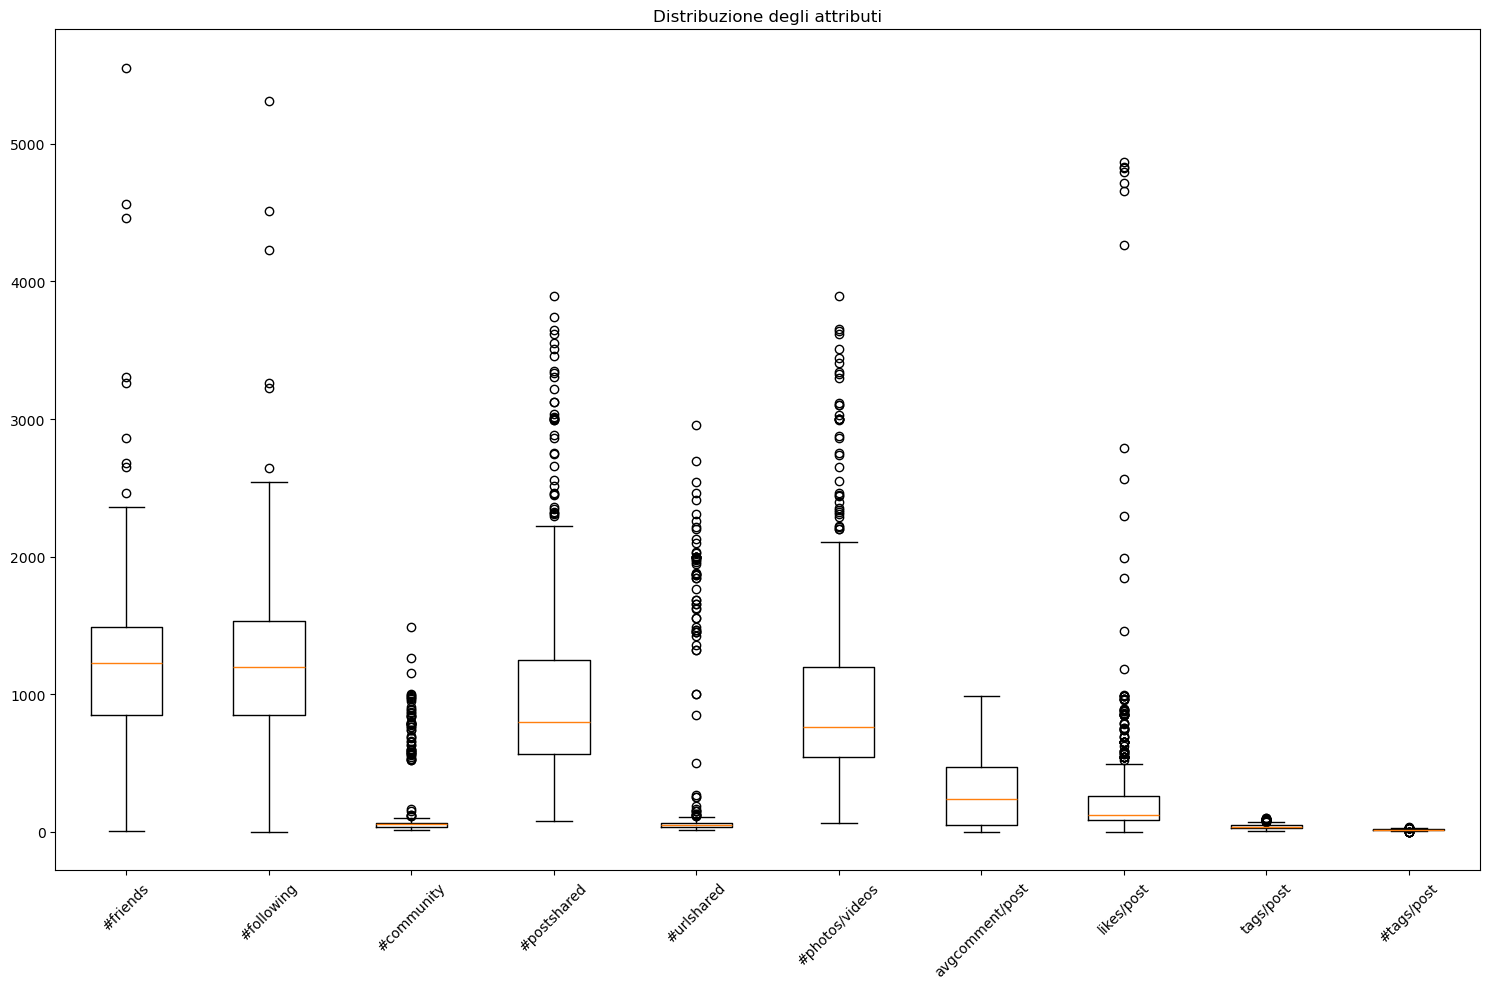

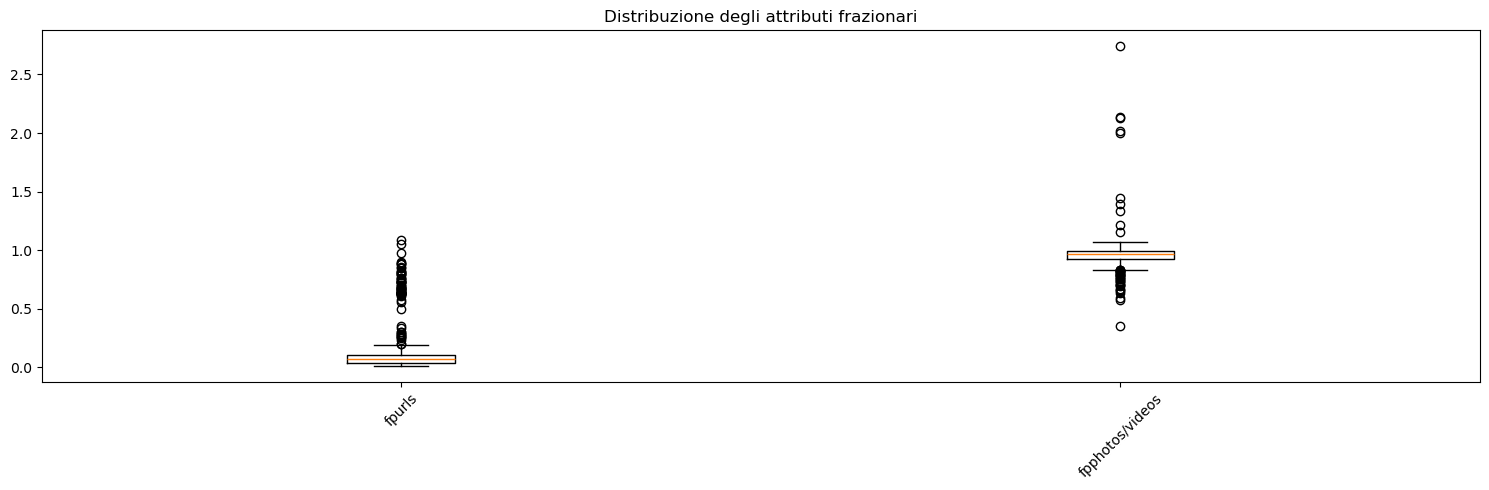

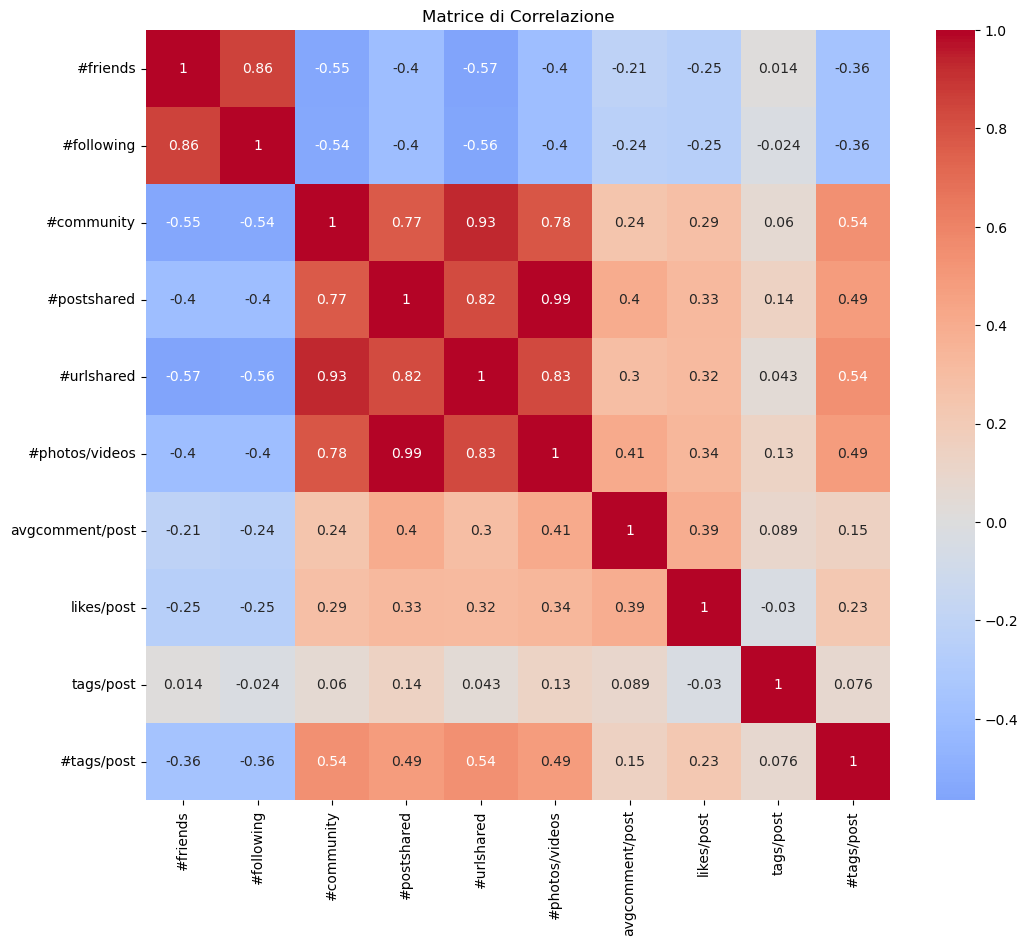

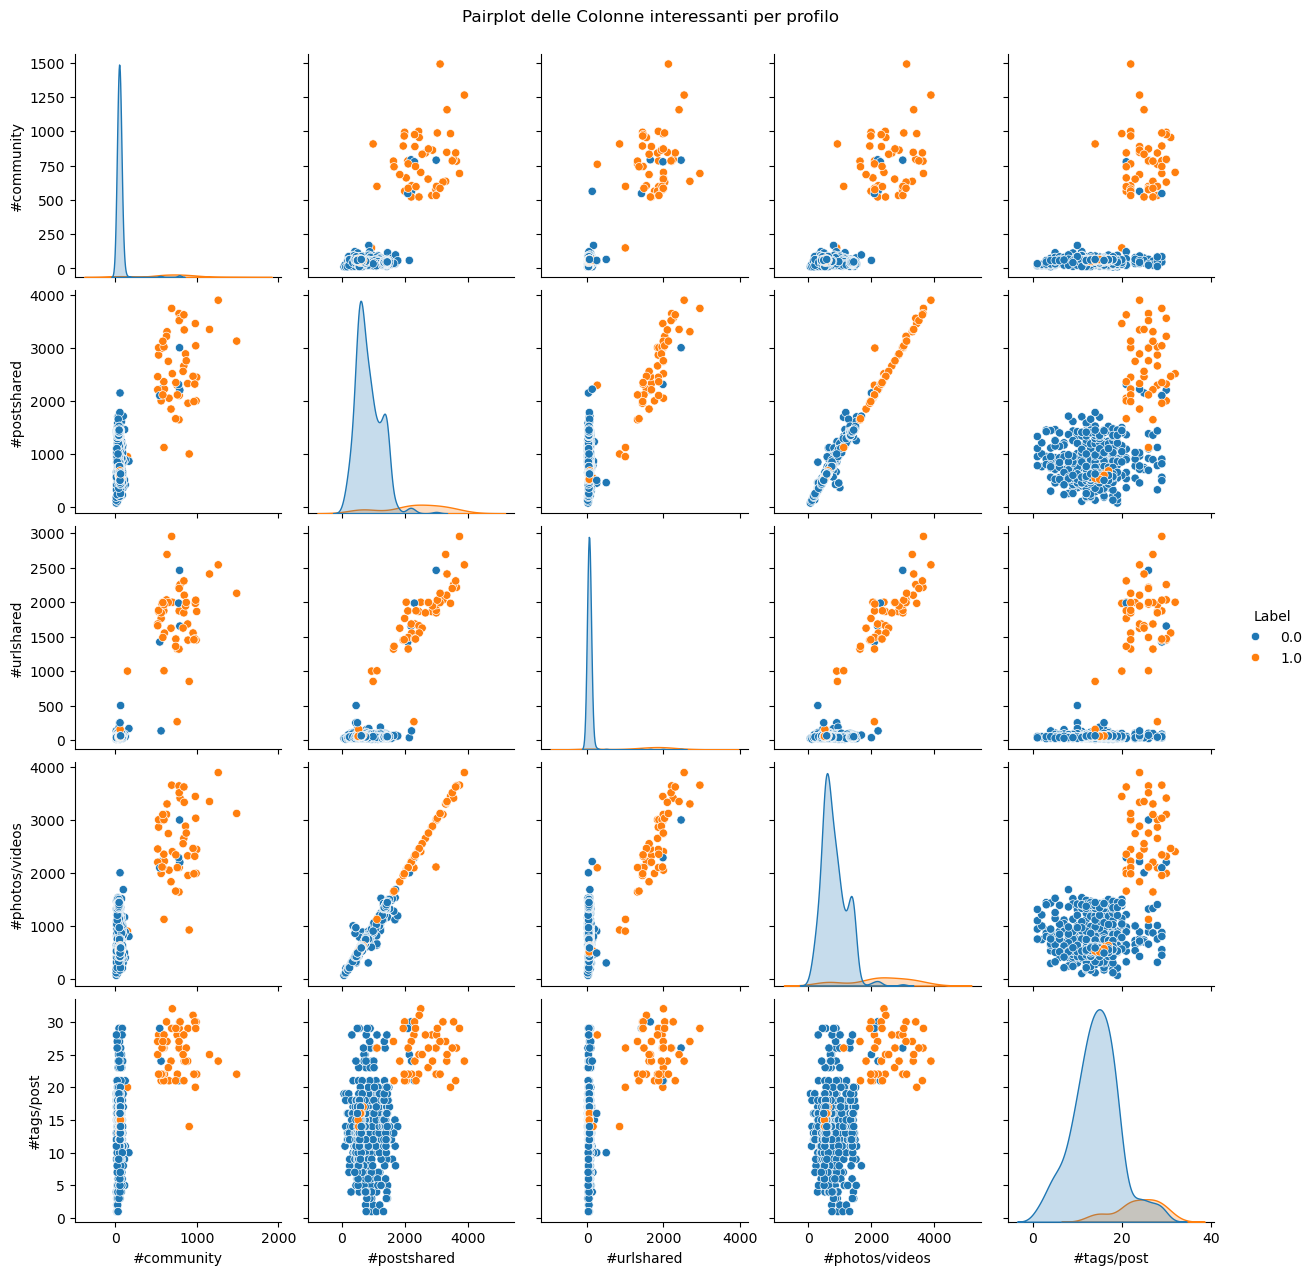

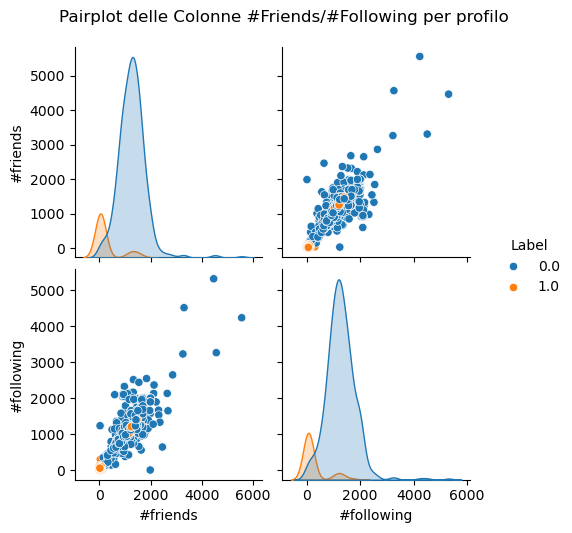

In [45]:
# 1. Boxplot
numeric_features = ['#friends', '#following', '#community', '#postshared', '#urlshared', '#photos/videos', 'avgcomment/post', 'likes/post', 'tags/post', '#tags/post']
fractions = ['fpurls', 'fpphotos/videos']
print(training_clean[numeric_features].describe().round(2))
plt.figure(figsize=(15, 10))
plt.boxplot([training_clean[feature] for feature in numeric_features])
plt.title('Distribuzione degli attributi')
plt.xticks(ticks=range(1, len(numeric_features) + 1), labels=numeric_features, rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([training_clean[fraction] for fraction in fractions])
plt.title('Distribuzione degli attributi frazionari')
plt.xticks(ticks=range(1, len(fractions) + 1), labels=fractions, rotation=45)
plt.tight_layout()
plt.show()


# 2. Matrice di correlazione
plt.figure(figsize=(12, 10))
corr_matrix = training_clean[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.show()

# 3. Pairplot per le feature principali dalla matrice di correlazione

# Pairplot delle principali feature
intersentig_col= ['#community', '#postshared', '#urlshared', '#photos/videos', '#tags/post']
friend_follow_col = ['#friends', '#following']
sns.pairplot(training_clean[intersentig_col + ['Label']], hue = 'Label')
plt.suptitle('Pairplot delle Colonne interessanti per profilo', y=1.02)
plt.show()
sns.pairplot(training_clean[friend_follow_col+ ['Label']], hue = 'Label')
plt.suptitle('Pairplot delle Colonne #Friends/#Following per profilo', y = 1.05)
plt.show()



# Task 3

Train: (384, 12), Test: (165, 12)
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.964
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.964
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.962
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.949
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.949
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.949
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.942
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.942
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.942

Decision Tree Manuale - Accuracy: 0.939
Report di classificazione Decision Tree Manuale:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       147
         1.0       0.90      0.50      0.64        18

    accuracy                           0.94       165
   macro avg       0.92      0.75      0.80       165
weighted avg       0.94      0.94      0.93       165



<Figure size 800x600 with 0 Axes>

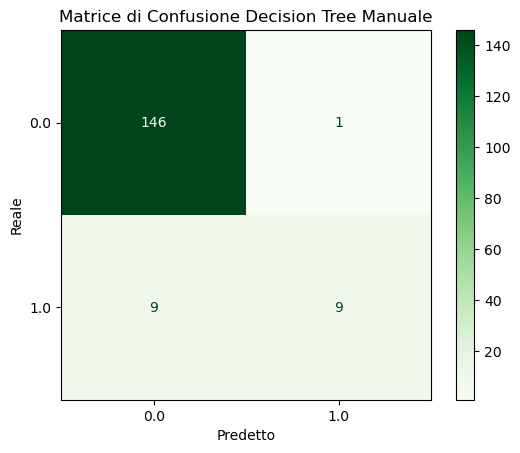


Naive Bayes Manuale - Accuracy: 0.964
Report di classificazione Naive Bayes Manuale:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       147
         1.0       0.93      0.72      0.81        18

    accuracy                           0.96       165
   macro avg       0.95      0.86      0.90       165
weighted avg       0.96      0.96      0.96       165



<Figure size 800x600 with 0 Axes>

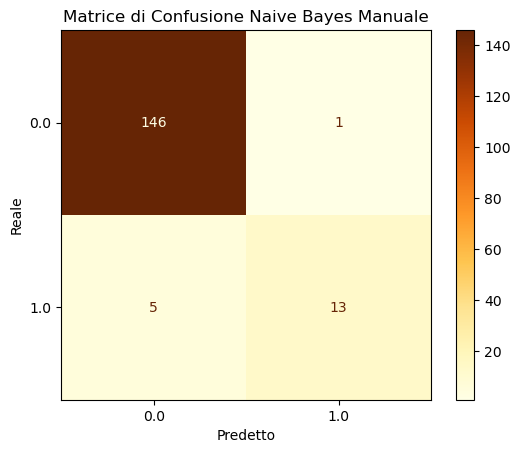

K=3 --> Accuracy media: 0.971
K=6 --> Accuracy media: 0.971
K=9 --> Accuracy media: 0.974

ManualKNN - Accuracy: 0.964
Report di classificazione KNN Manuale:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       147
         1.0       0.93      0.72      0.81        18

    accuracy                           0.96       165
   macro avg       0.95      0.86      0.90       165
weighted avg       0.96      0.96      0.96       165



<Figure size 800x600 with 0 Axes>

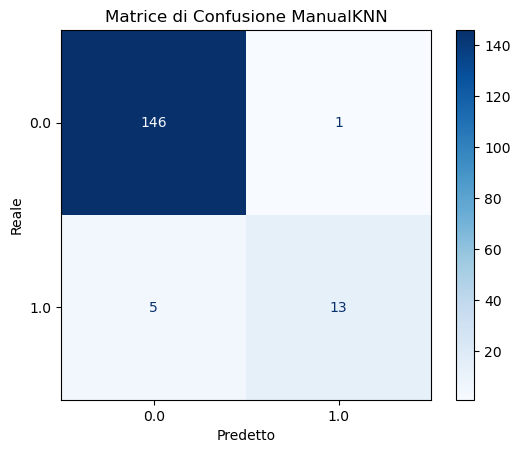

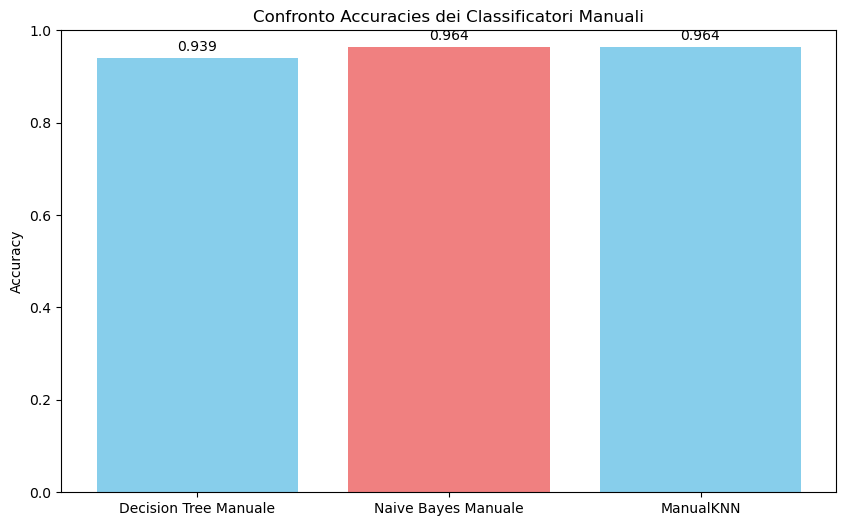

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd


#Inilizzazione parametri
feature_cols = ['#friends', '#following', '#community', '#postshared', '#urlshared', 
                '#photos/videos', 'avgcomment/post', 'likes/post', 'tags/post', '#tags/post', 'fpurls', 'fpphotos/videos']

X = training_clean[feature_cols].values
y = training_clean['Label'].values

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split sul set normalizzato
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X_scaled, y, test_size = 0.3, random_state = 15, stratify = y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15, stratify = y)


print(f"Train: {X_train.shape}, Test: {X_test.shape}")

#test sul Decision tree, testiamo diverse profondità

max_levels = [3, 5, 10]
min_samples = [2, 3, 5]

results_dt = []

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for max_level in max_levels:
    for min_sample in min_samples:
        accuracies_dt = []

        for train_idx, val_idx in cv.split(X, y):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            model = SimpleDecisionTreeClassifier(max_levels = max_level, min_samples = min_sample)
            model.train(X_train_cv, y_train_cv)
            y_pred = model.classify(X_val_cv)

            acc = accuracy_score(y_val_cv, y_pred)
            accuracies_dt.append(acc)

        mean_acc = np.mean(accuracies_dt)
        results_dt.append({
            'max_levels': max_levels,
            'min_samples_split': min_samples,
            'mean_accuracy': mean_acc
        })
        print(f"max_depth={max_levels}, min_split={min_samples} --> acc={mean_acc:.3f}")


dt = SimpleDecisionTreeClassifier(max_levels=5, min_samples=5)
dt.train(X_train, y_train)
dt_pred = dt.classify(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"\nDecision Tree Manuale - Accuracy: {dt_acc:.3f}")
print("Report di classificazione Decision Tree Manuale:")
print(classification_report(y_test, dt_pred))

# Confusion matrix decision tree
cm = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Greens', values_format='d')
plt.title("Matrice di Confusione Decision Tree Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


# Test Naive Bayes manuale
nb = ManualNaiveBayes()
nb.fit(X_trainS, y_trainS)
nb_pred = nb.predict(X_testS)
nb_acc = accuracy_score(y_testS, nb_pred)

print(f"\nNaive Bayes Manuale - Accuracy: {nb_acc:.3f}")
print("Report di classificazione Naive Bayes Manuale:")
print(classification_report(y_testS, nb_pred))

# Confusion matrix Bayes
cm_bayes = confusion_matrix(y_testS, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='YlOrBr', values_format='d')
plt.title("Matrice di Confusione Naive Bayes Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


k_values = [3, 6, 9]

results_knn = []

for k in k_values:
    accuracies_knn = []

    for train_idx, val_idx in cv.split(X_scaled, y):  
        X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]

        # Inizializza e addestra KNN manuale
        knn = ManualKNN(k=k)
        knn.fit(X_train_cv, y_train_cv)
        y_pred = knn.predict(X_val_cv)

        acc = accuracy_score(y_val_cv, y_pred)
        accuracies_knn.append(acc)

    mean_acc = np.mean(accuracies_knn)
    results_knn.append({'k': k, 'mean_accuracy': mean_acc})
    print(f"K={k} --> Accuracy media: {mean_acc:.3f}")



knn = ManualKNN(k = 3)
knn.fit(X_trainS, y_trainS)
knn_pred = knn.predict(X_testS)
knn_acc = accuracy_score(y_testS, knn_pred)

print(f"\nManualKNN - Accuracy: {knn_acc:.3f}")
print("Report di classificazione KNN Manuale:")
print(classification_report(y_testS, knn_pred))

cm_knn = confusion_matrix(y_testS, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione ManualKNN")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


# Confronto visivo delle performance
plt.figure(figsize=(10, 6))
labels = ['Decision Tree Manuale', 'Naive Bayes Manuale', 'ManualKNN']
accuracies = [dt_acc, nb_acc, knn_acc]
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Confronto Accuracies dei Classificatori Manuali')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Aggiungiamo le etichette di accuracy sopra le barre
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.show()

# Task 4

In [47]:
from sklearn.model_selection import train_test_split
#Inizializzazione parametri
feature_cols = ['#friends', '#following', '#community', '#postshared', '#urlshared', 
                '#photos/videos', 'avgcomment/post', 'likes/post', 'tags/post', '#tags/post', 'fpurls', 'fpphotos/videos']

X = training_clean[feature_cols].values
y = training_clean['Label'].values

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split sul set normalizzato
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X_scaled, y, test_size = 0.3, random_state = 15, stratify = y)
#split sul set normale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15, stratify = y)

Fitting 5 folds for each of 112 candidates, totalling 560 fits

--- Iperparametri Ottimali ---
Migliori iperparametri trovati:
{'C': 0.0001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Migliore accuratezza CV: 0.9793

--- Report di Classificazione sul Test Set ---
              precision    recall  f1-score   support

         0.0     0.9669    0.9932    0.9799       147
         1.0     0.9286    0.7222    0.8125        18

    accuracy                         0.9636       165
   macro avg     0.9477    0.8577    0.8962       165
weighted avg     0.9627    0.9636    0.9616       165

Accuratezza del miglior modello sul test set: 0.9636

--- Matrice di Confusione ---


<Figure size 800x600 with 0 Axes>

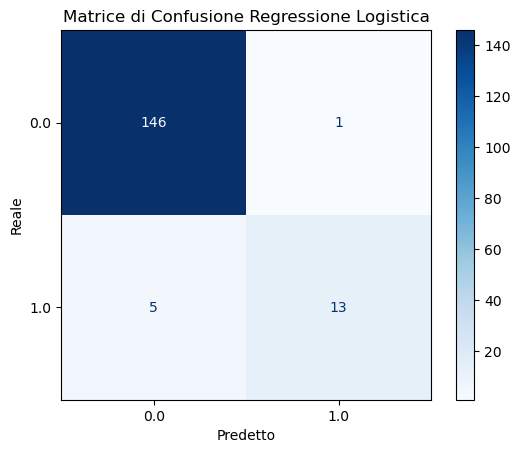

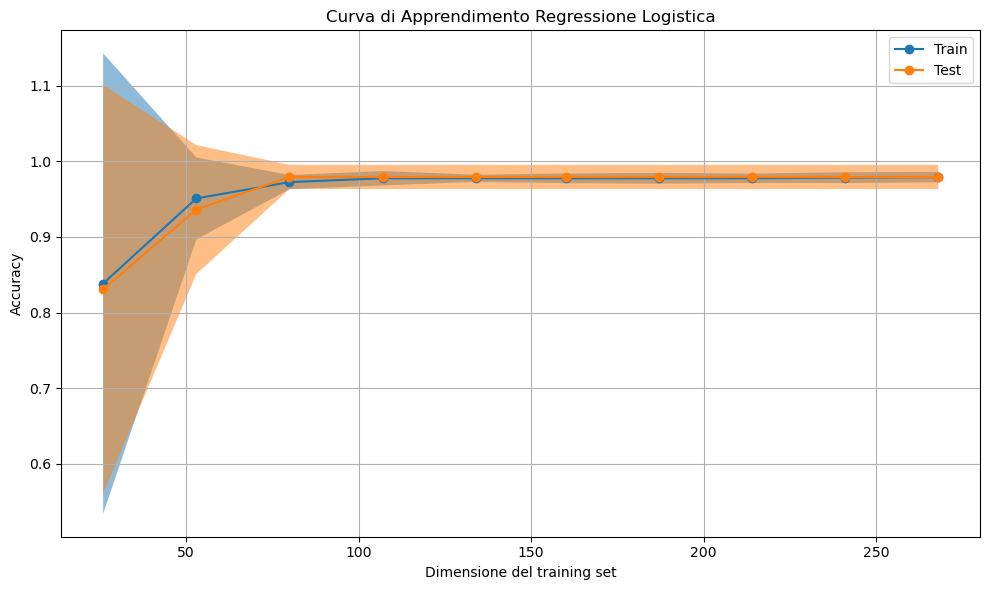

In [59]:
#Logistic Regression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay, ShuffleSplit
import warnings
warnings.filterwarnings("ignore")

lr = LogisticRegression(random_state=15, max_iter=5000)

# Definizione della griglia degli iperparametri per la Logistic Regression
param_grid = [
    {
        'penalty': ['l1'],  
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
        'solver': ['saga'],
        'class_weight': [None, 'balanced'],
    },
    {
        'penalty': ['l2', 'none'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga', 'lbfgs'],
        'class_weight': [None, 'balanced'],
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'class_weight': [None, 'balanced'],
        'l1_ratio': [0, 0.5, 1],
    }
]

# Configurazione GridSearchCV
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=15),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1, 
)

#Esecuzione della ricerca sugli iper-parametri
grid.fit(X_trainS, y_trainS)

# Iperparametri ottimali
print("\n--- Iperparametri Ottimali ---")
print("Migliori iperparametri trovati:")
print(grid.best_params_)
print(f"Migliore accuratezza CV: {grid.best_score_:.4f}")

# Valutazione sul test set
y_pred = grid.predict(X_testS)
print("\n--- Report di Classificazione sul Test Set ---")
print(classification_report(y_testS, y_pred, digits=4))

lr_model = grid.best_estimator_
accuracy_lr = lr_model.score(X_testS, y_testS)

print(f"Accuratezza del miglior modello sul test set: {lr_model.score(X_testS, y_testS):.4f}")

# --- Matrice di Confusione ---
print("\n--- Matrice di Confusione ---")
cm = confusion_matrix(y_testS, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione Regressione Logistica")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# --- Curva di Apprendimento ---
validation_params = {
    "X": X_trainS,
    "y": y_trainS,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.3, random_state=15),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

fig, ax = plt.subplots(figsize=(10, 6))
LearningCurveDisplay.from_estimator(estimator=lr_model, ax=ax, **validation_params)

ax.set_title("Curva di Apprendimento Regressione Logistica")
ax.set_xlabel("Dimensione del training set")
ax.set_ylabel("Accuracy")
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Migliori Iperparametri Trovati
Parametri Ottimali: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 100}
   Accuratezza CV Ottimale: 0.9791
Ottimizzazione completata. Modello migliore recuperato.

Valutazione Finale del Modello
 Accuratezza sul Set di Test (dati mai visti): 0.9576

Report di Classificazione Dettagliato
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       147
         1.0       0.92      0.67      0.77        18

    accuracy                           0.96       165
   macro avg       0.94      0.83      0.88       165
weighted avg       0.96      0.96      0.95       165



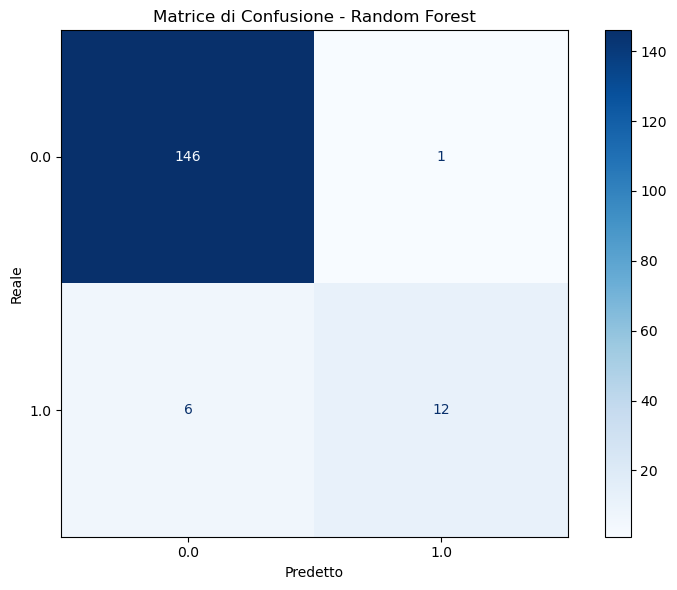

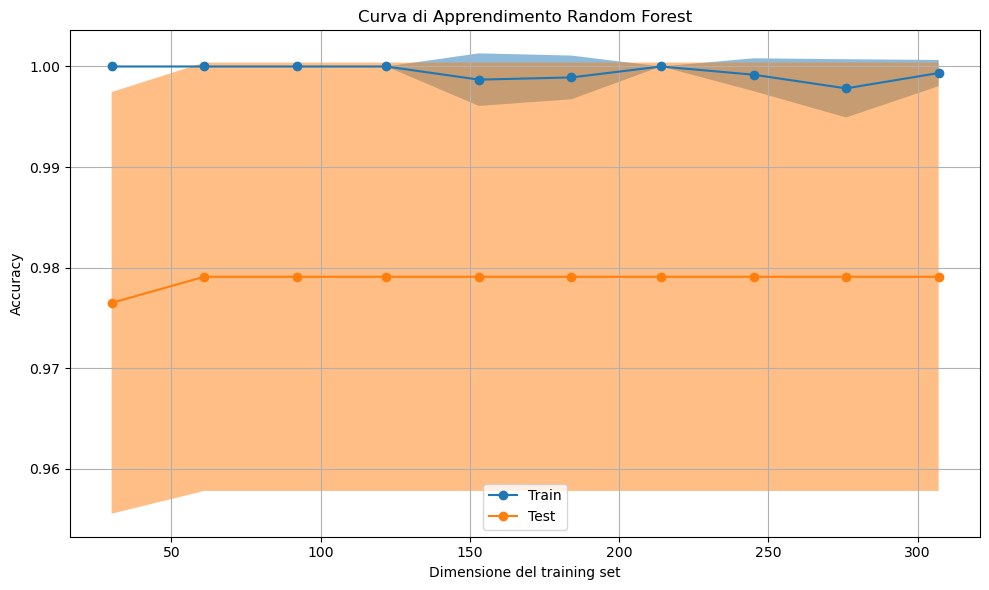

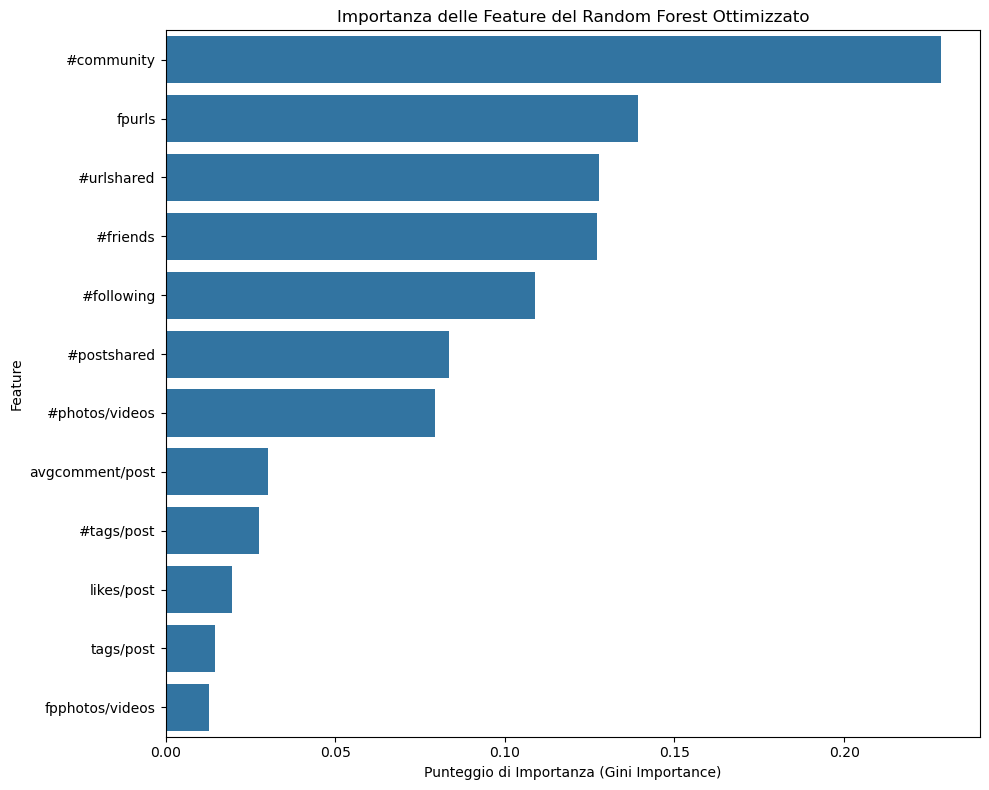

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Definizione della griglia di iperparametri da esplorare
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [3, 5, 10],
    'max_features': ['log2', 'sqrt']
}

# Inizializzazione del modello base Random Forest
rf = RandomForestClassifier(random_state=15)

# Configurazione dello strumento GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Metrica di valutazione: accuratezza
    n_jobs=-1,            # Utilizza tutti i core disponibili
    verbose=1             # Output del progresso
)


grid_search.fit(X_train, y_train)

print("\nMigliori Iperparametri Trovati")
# Identifica e stampa i migliori iperparametri e il loro punteggio
print("Parametri Ottimali:", grid_search.best_params_)
print(f"   Accuratezza CV Ottimale: {grid_search.best_score_:.4f}")
print("Ottimizzazione completata. Modello migliore recuperato.\n")

# Valutazione Finale sul Test Set
print("Valutazione Finale del Modello")

# Recupera il modello migliore già addestrato (con i parametri ottimali)
model_forest = grid_search.best_estimator_

# Valuta il modello migliore sul set di test SCALATO
accuracy_rf = model_forest.score(X_test, y_test)
print(f" Accuratezza sul Set di Test (dati mai visti): {accuracy_rf:.4f}")

# Genera le previsioni sul test set scalato
y_pred = model_forest.predict(X_test)

print("\nReport di Classificazione Dettagliato")
print(classification_report(y_test, y_pred))

# Matrice di Confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca()) # Usa ax=plt.gca() per evitare deprecation warning in alcune versioni
plt.title('Matrice di Confusione - Random Forest')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.tight_layout()
plt.show()


# Generazione della Learning Curve
validation_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

fig, ax = plt.subplots(figsize=(10, 6))
LearningCurveDisplay.from_estimator(model_forest, ax=ax, **validation_params)

ax.set_title("Curva di Apprendimento Random Forest")
ax.set_xlabel("Dimensione del training set")
ax.set_ylabel("Accuracy")
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()

# Grafico Feature Importance
importances = model_forest.feature_importances_
feature_names = feature_cols# Usa i nomi delle colonne dai dati scalati
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_series, y=feature_importance_series.index)
plt.title('Importanza delle Feature del Random Forest Ottimizzato')
plt.xlabel('Punteggio di Importanza (Gini Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 336 candidates, totalling 1680 fits

Best hyperparameters found:
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best CV Accuracy: 0.9791

Classification report on test set:
              precision    recall  f1-score   support

         0.0    0.96053   0.99320   0.97659       147
         1.0    0.92308   0.66667   0.77419        18

    accuracy                        0.95758       165
   macro avg    0.94180   0.82993   0.87539       165
weighted avg    0.95644   0.95758   0.95451       165

0.9575757575757575


<Figure size 800x600 with 0 Axes>

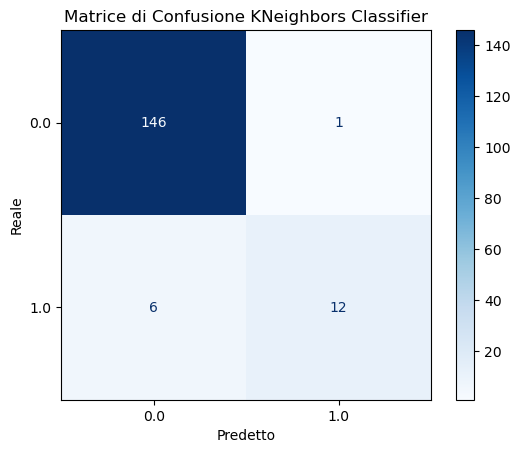

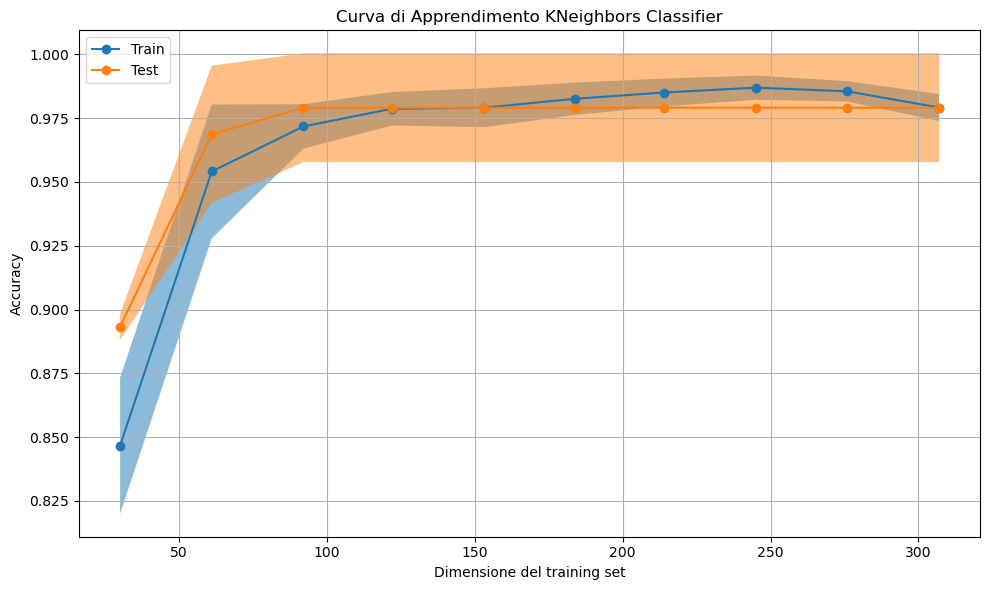

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [10, 15, 20, 25, 30, 35, 40],
    'weights': ['uniform', 'distance'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan'], 
    'leaf_size': [20, 30, 40, 50]
}

# Inizializzazione del modello base Random Forest
knn = KNeighborsClassifier()

# Configurazione dello strumento GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Metrica di valutazione: accuratezza
    n_jobs=-1,            # Utilizza tutti i core disponibili
    verbose=1             # Output del progresso
)

# Esecuzione della ricerca sugli iper-parametri
grid_search.fit(X_trainS, y_trainS)

# Iperparametri ottimali
print("\nBest hyperparameters found:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Valutazione sul test set
y_pred = grid_search.predict(X_testS)
print("\nClassification report on test set:")
print(classification_report(y_testS, y_pred, digits=5))

knn_model = grid_search.best_estimator_
accuracy_knn = knn_model.score(X_testS, y_testS)
print(knn_model.score(X_testS, y_testS))

#Confusion Matrix
cm = confusion_matrix(y_testS, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione KNeighbors Classifier")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

validation_params = {
    "X": X_trainS,
    "y": y_trainS,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

fig, ax = plt.subplots(figsize=(10, 6))
LearningCurveDisplay.from_estimator(estimator = knn_model, ax=ax, **validation_params)

ax.set_title("Curva di Apprendimento KNeighbors Classifier")
ax.set_xlabel("Dimensione del training set")
ax.set_ylabel("Accuracy")
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Risultati Cross-Validation:
{'var_smoothing': 1e-09} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 5e-09} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 1e-08} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 5e-08} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 1e-07} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 5e-07} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 1e-06} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 5e-06} -> Mean CV Accuracy: 0.97908 (±0.02130)
{'var_smoothing': 1e-05} -> Mean CV Accuracy: 0.97908 (±0.02130)

Migliori hyperparametri trovati per GaussianNB:
{'var_smoothing': 1e-09}
Best CV Accuracy: 0.97908

Classification report sul test set (GaussianNB):
              precision    recall  f1-score   support

         0.0     0.9669    0.9932    0.9799       147
         1.0     0.9286    0.7222    0.8125        18

    accuracy 

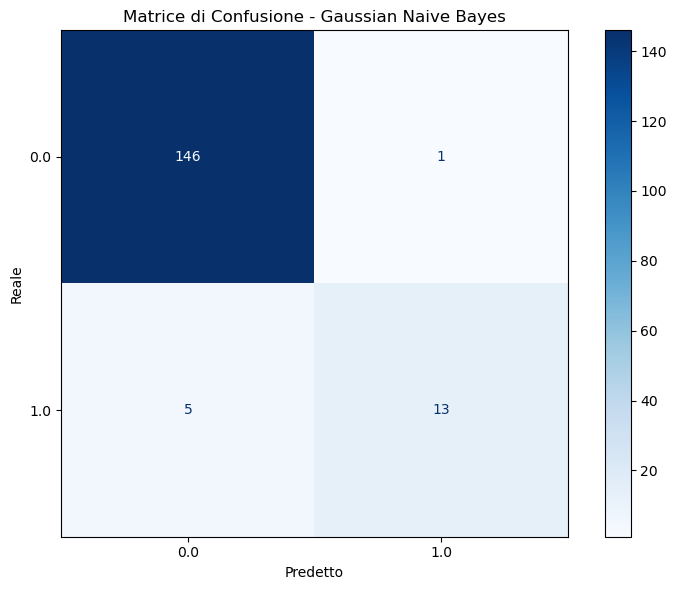

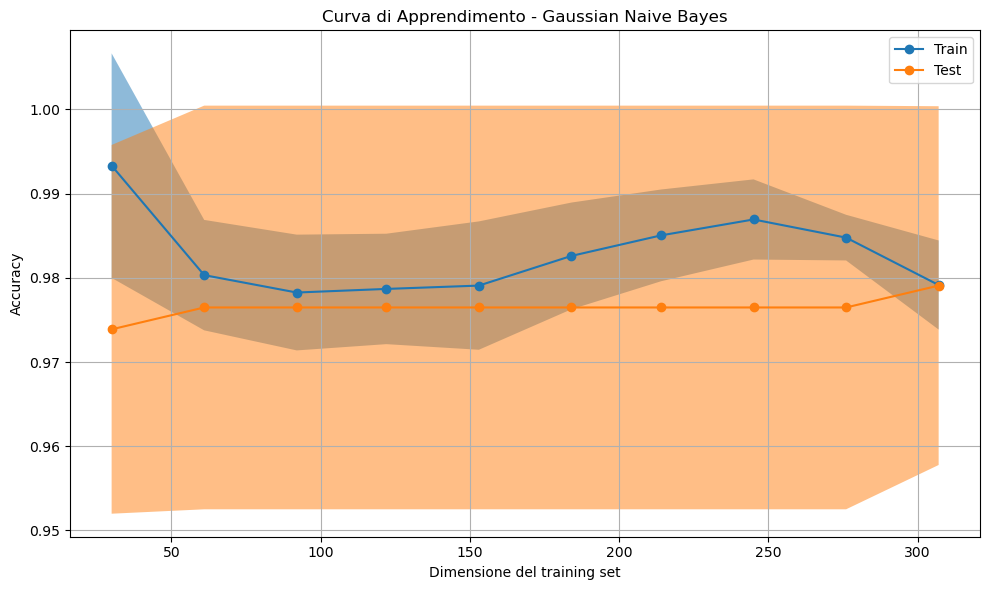

In [57]:
# ------------------------- Gaussian Naive Bayes con tuning -------------------------

# Griglia personalizzata per var_smoothing
param_grid_nb = {
    'var_smoothing': [1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
}

# Inizializza il classificatore
gnb = GaussianNB()

# GridSearchCV con validazione incrociata a 5 fold
grid_nb = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ricerca degli iperparametri
grid_nb.fit(X_trainS, y_trainS)

# Risultati delle combinazioni testate
results_nb = grid_nb.cv_results_
print("Risultati Cross-Validation:")
for mean_score, std_score, params in zip(
        results_nb['mean_test_score'],
        results_nb['std_test_score'],
        results_nb['params']):
    print(f"{params} -> Mean CV Accuracy: {mean_score:.5f} (±{std_score:.5f})")

# Miglior modello trovato
print("\nMigliori hyperparametri trovati per GaussianNB:")
print(grid_nb.best_params_)
print(f"Best CV Accuracy: {grid_nb.best_score_:.5f}")

# --------------------------- Valutazione sul test set ---------------------------

# Predizione
model_Bayes = grid_nb.best_estimator_
y_pred_nb = model_Bayes.predict(X_testS)

# Report
print("\nClassification report sul test set (GaussianNB):")
print(classification_report(y_testS, y_pred_nb, digits=4))

# Accuratezza
accuracy_NB = model_Bayes.score(X_testS, y_testS)
print(f"Accuracy su test set: {accuracy_NB:.4f}")

# Matrice di confusione
cm = confusion_matrix(y_testS, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Matrice di Confusione - Gaussian Naive Bayes')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.tight_layout()
plt.show()

# --------------------------- Curva di apprendimento ---------------------------

# Parametri per la curva di apprendimento
validation_params = {
    "X": X_trainS,
    "y": y_trainS,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

fig, ax = plt.subplots(figsize=(10, 6))
LearningCurveDisplay.from_estimator(model_Bayes, ax=ax, **validation_params)
ax.set_title("Curva di Apprendimento - Gaussian Naive Bayes")
ax.set_xlabel("Dimensione del training set")
ax.set_ylabel("Accuracy")
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()

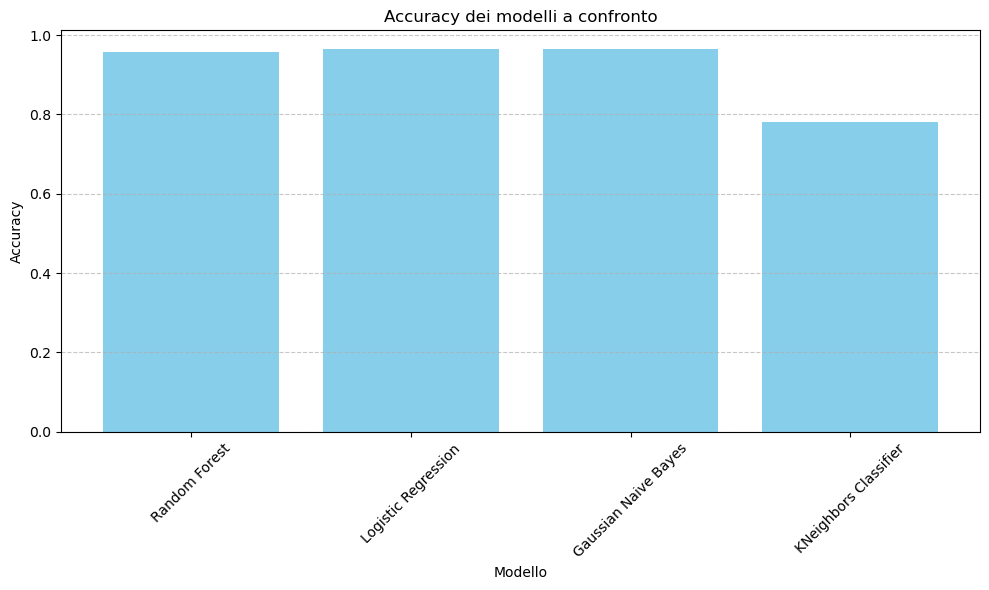

Random Forest: 0.9575757575757575 
Logistic Regression: 0.9636363636363636 
KNeighbors Classifier: 0.7818181818181819 
Gaussian Naive Bayes: 0.9636363636363636


In [60]:
accuracies = {
    'Random Forest': accuracy_rf,
    'Logistic Regression': accuracy_lr,
    'Gaussian Naive Bayes': accuracy_NB,
    'KNeighbors Classifier': accuracy_knn
}

# Plot delle accuracy dei modelli per confronto
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Modello')
plt.title('Accuracy dei modelli a confronto')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print('Random Forest:', accuracy_rf, 
      '\nLogistic Regression:', accuracy_lr, 
      '\nKNeighbors Classifier:', accuracy_knn, 
      '\nGaussian Naive Bayes:', accuracy_NB)